In [1]:
# Imports

import xarray as xr

import glob
print(glob.glob("/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/*"))

['/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201201.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201202.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201203.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201204.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201205.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201206.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201207.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201208.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201209.nc', '/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SA

In [2]:
ds = xr.open_dataset('/gws/nopw/j04/acrg/acrg/elenafi/example_footprints/INDIA/GOSAT-INDIA-SAM-column_SOUTHASIA_201502.nc')
print(ds)

<xarray.Dataset> Size: 93MB
Dimensions:               (time: 561, lon: 155, lat: 180, lev: 1, height: 20)
Coordinates:
  * time                  (time) datetime64[ns] 4kB 2015-02-01T07:40:57.33333...
  * lon                   (lon) float32 620B 55.0 55.35 55.7 ... 108.9 109.2
  * lat                   (lat) float32 720B 6.0 6.234 6.468 ... 47.65 47.89
  * lev                   (lev) <U6 24B 'column'
  * height                (height) float32 80B 500.0 1.5e+03 ... 1.95e+04
Data variables:
    fp                    (lat, lon, time) float32 63MB ...
    temperature           (time) float32 2kB ...
    pressure              (time) float32 2kB ...
    wind_speed            (time) float32 2kB ...
    wind_direction        (time) float32 2kB ...
    PBLH                  (time) float32 2kB ...
    release_lon           (time) float32 2kB ...
    release_lat           (time) float32 2kB ...
    particle_locations_n  (height, lon, time) float32 7MB ...
    particle_locations_e  (height, lat, ti

In [2]:
import iris
import os
import sys
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xarray as xr
import gzip
import dask
import shutil
import argparse
import yaml
import gc
from dask.diagnostics import ProgressBar


In [3]:
# met functions
def get_default_paths():
    # Moving all hard-coded locations to config.yaml.
    # To remove this function as soon as I've finished with satellite_met_join_v2.py
    stratch = "/work/scratch-nopw2/jeff/"

    paths = {"stratch":stratch}

    return paths

def get_saved_region_bounds():
    """
    Get the bounds of each world region
    """
    """
    # these are actually incorrect but plot the correct lines - something to do with wrapping around the edges
    
    region_bounds = {1: [79.921875, 89.953125, -179.92969, 179.92969],
        10: [-80.015625, -24.984375, -45.070312, 45.070312],
        11: [-80.015625, -24.984375, 44.929688, 135.07031],
        12: [-80.015625, -24.984375, -179.92969, 179.92969],
        13: [-80.015625, -24.984375, -135.07031, -44.929688],
        14: [-89.953125, -79.921875, -179.92969, 179.92969],
        2: [24.984375, 80.015625, -45.070312, 45.070312],
        3: [24.984375, 80.015625, 44.929688, 135.07031],
        4: [24.984375, 80.015625, -179.92969, 179.92969],
        5: [24.984375, 80.015625, -135.07031, -44.929688],
        6: [-25.078125, 25.078125, -45.070312, 45.070312],
        7: [-25.078125, 25.078125, 44.929688, 135.07031],
        8: [-25.078125, 25.078125, -179.92969, 179.92969],
        9: [-25.078125, 25.078125, -135.07031, -44.929688]}
    """
    region_bounds =    {1: [79.921875, 89.953125, 0.0703125, -0.0703125],
        2: [24.984375, 80.015625, -45.070312, 45.070312],
        3: [24.984375, 80.015625, 44.929688, 135.07031],
        4: [24.984375, 80.015625, 134.92969, -134.92969],
        5: [24.984375, 80.015625, -135.07031, -44.929688],
        6: [-25.078125, 25.078125, -45.070312, 45.070312],
        7: [-25.078125, 25.078125, 44.929688, 135.07031],
        8: [-25.078125, 25.078125, 134.92969, -134.92969],
        9: [-25.078125, 25.078125, -135.07031, -44.929688],
        10: [-80.015625, -24.984375, -45.070312, 45.070312],
        11: [-80.015625, -24.984375, 44.929688, 135.07031],
        12: [-80.015625, -24.984375, 134.92969, -134.92969],
        13: [-80.015625, -24.984375, -135.07031, -44.929688],
        14: [-89.953125, -79.921875, 0.0703125, -0.0703125],
        }

    return region_bounds

def find_overlapping_regions(min_lat, max_lat, min_lon, max_lon):
    """
    Given a bounding box (min/max latitude and longitude), return the region IDs that overlap.


    Returns:
    list: Region IDs that overlap with the given domain
    """
    region_bounds = get_saved_region_bounds()
    overlapping_regions = []

    for region_id, (r_min_lat, r_max_lat, r_min_lon, r_max_lon) in region_bounds.items():
        # Check if the bounding boxes overlap
        lat_overlap = not (max_lat < r_min_lat or min_lat > r_max_lat)
        lon_overlap = not (max_lon < r_min_lon or min_lon > r_max_lon)

        if lat_overlap and lon_overlap:
            overlapping_regions.append(region_id)

    return overlapping_regions


def load_iris(filepath, Mk, date, vars, num, homefolder):
    bad_files = ["MO201402011500.UMG_Mk7_I_L59PT9.pp"] 
    # mk10 files are already unzipped, can load directly - changed, trying this
    if Mk == 10:
        filename = filepath[0]+date+filepath[1]+ str(num) + ".pp"
        print(filename, len(glob.glob(filename)))
        try:
            # load
            loaded = iris.load(glob.glob(filename), vars, callback=remove_coord_callback)

        except Exception as e:
            # delete all files if something fails
            print("something failed: ", e )
            os.system("rm -r " + homefolder + "MO"+date+"*")     
    # rest of mks needs to be unzipped in a different directory
    else:
        filename = filepath[0]+date+filepath[1]+ str(num) + ".pp.gz"
        files = glob.glob(filename)
        print(filename, len(glob.glob(filename)))
        print(homefolder+date+filepath[1]+ str(num) + ".pp")
        homefiles = glob.glob(homefolder+"*"+date+filepath[1]+ str(num) + ".pp")
        nhomefiles = len(homefiles)
        #print(list(set([os.path.basename(f).replace(".gz", "") for f in files]) - set([os.path.basename(f) for f in homefiles])))
        print(len(homefiles), len(files))

        # Load config.yaml to save to updates.txt
        with open("config.yaml", "r") as f:
            config = yaml.safe_load(f)
        scripts_text = config.get("scripts_text_save_location", "")
        if len(homefiles)==len(files):
            txtfile = open(scripts_text, "a+")
            txtfile.write(date + str(num) + "  " + str(datetime.datetime.now()) + " --- loading data from scratch --- \n")
            txtfile.close()   
            print("needed files are already in homefolder. Loading without copying")
            bad_files = [homefolder+f for f in bad_files]
            homefiles = list(set(homefiles) - set(bad_files))
            if len(homefiles) < nhomefiles:
                print(str(nhomefiles-len(homefiles)), " files removed")
            try:
                print("attempt loading")
                loaded = iris.load(homefiles, vars, callback=remove_coord_callback)
                txtfile = open(scripts_text, "a")
                txtfile.write(date + str(num) + "  " + str(datetime.datetime.now()) + " data loaded (directly from homefolder)\n")
                txtfile.close()  
            except Exception as e:
                print("something failed: ", e )
        try:
            all_outs = []
            for f in files:
                filename = os.path.basename(f)
                filename = filename.replace(".gz", "")
                # unzip and copy to scratch
                with gzip.open(f, 'rb') as f_in:
                    with open(homefolder+filename, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                        if filename not in bad_files:
                            all_outs.append(homefolder+filename)
            print("all copied")
            # load
            loaded = iris.load(all_outs, vars, callback=remove_coord_callback)
            print("loaded")
        except Exception as e:
            # delete all files if something fails
            print("something failed: ", e )
            #os.system("rm -r " + homefolder + "MO"+date+"*")
            
    return loaded

def delete_iris(homefolder, date, num):
    os.system("rm -r " + homefolder + "MO"+date+"*"+ str(num) + ".pp")

def remove_coord_callback(cube, field, filename):
    if "um_version" in cube.attributes.keys():
        cube.attributes.pop("um_version")

def daterange(start_date, end_date, a_day_only=False):
    start_date = np.datetime64(start_date)
    if a_day_only:
        end_date = np.datetime64(start_date) + np.timedelta64(24, 'h') # use this when debugging only with one day
    else:
        end_date = np.datetime64(end_date)
    dates = []
    datenow = start_date + np.timedelta64(0, 'h')
    while datenow < end_date:
        dates.append(np.datetime64(datenow))
        datenow = datenow + np.timedelta64(1, 'h')
    return np.array(dates)

def get_Mk(year, month):
    # find file naming convention for date
    if year==2011 or year==2012 or (year == 2013 and month in ["01", "02", "03", "04"]):
        Mk = 6
    elif (year == 2013 and month in ["05", "06", "07","08", "09", "10", "11", "12"]) or (year == 2014 and month in ["01", "02", "03", "04", "05", "06"]):
        Mk = 7
    elif (year == 2014 and month in ["07", "08", "09", "10", "11", "12"]) or (year == 2015 and month in ["01", "02", "03", "04", "05", "06", "07"]):
        Mk = 8
    elif (year == 2015 and month in ["08", "09", "10", "11", "12"]) or (year == 2016) or (year == 2017 and month in ["01", "02", "03", "04", "05", "06"]):
        Mk = 9
    elif (year == 2017 and month in ["07", "08", "09", "10", "11", "12"]) or (year > 2017 and (year < 2022 or (year == 2022 and month in ["01", "02", "03", "04", "05"]))):
        Mk = 10
    elif (year == 2022 and month in ["06", "07", "08", "09", "10", "11", "12"]) or (year > 2022):
        Mk = 11
    else:
        print("No Mk found for this year and month")
        raise ValueError(f"No Mk version found for year={year}, month={month}")
    return Mk

def get_edge_size(domain, size_type):

    # Retrieve the domain or global default edge size from the yaml configuration file
    with open("config.yaml", "r") as f:
        config = yaml.safe_load(f)

    default_edge_size = config.get('default_edge_size', [100, 100])

    try:
        return config['domains'][domain].get(size_type, default_edge_size)
    except KeyError:
        return default_edge_size

def build_domain_grid(global_grid, regions_to_include):
    """
    Given the global region grid and a list of regions to include for a given domain, return a trimmed grid
    that only contains the specified regions.
    """
    # Create a mask for the regions to include
    trimmed_grid = []
    for row in global_grid:
        new_row = [cell if cell in regions_to_include else None for cell in row]
        if any(cell is not None for cell in new_row):  # Keep rows with at least one valid region
            trimmed_grid.append(new_row)

    # Now trim columns (transpose → filter → transpose back)
    transposed = list(map(list, zip(*trimmed_grid)))
    trimmed_transposed = [
        col for col in transposed if any(cell is not None for cell in col)
    ]
    final_grid = list(map(list, zip(*trimmed_transposed)))  # Back to row-major

    return final_grid

def drop_duplicate_coords(ds, dim):
    """
    Drop duplicate coordinate values along a given dimension
    """
    coord_vals = ds[dim].values
    _, unique_idx = np.unique(coord_vals, return_index=True)
    if len(unique_idx) < len(coord_vals):
        print(f"Dropping {len(coord_vals) - len(unique_idx)} duplicate values in '{dim}'")
    return ds.isel({dim: sorted(unique_idx)})

In [5]:
def plot_met_file(filepath, variables=None, time_index=0, level_index=0):
    """
    Plots selected variables from a given .nc file at a specified model level and time.

    Parameters:
        filepath (str): Path to the .nc file.
        variables (list of str, optional): List of variable names to plot. Default is ['x_wind', 'y_wind', 'air_temperature'].
        time_index (int): Index of the time slice to plot.
        level_index (int): Index of the model level to plot.
    """
    if variables is None:
        variables = ['x_wind', 'y_wind', 'air_temperature']
    
    try:
        ds = xr.open_dataset(filepath)
        file_name = os.path.basename(filepath)
        
        # Create subplots
        fig, axes = plt.subplots(1, len(variables), figsize=(5 * len(variables), 6))
        if len(variables) == 1:
            axes = [axes]  # Ensure it's iterable
        
        for i, var in enumerate(variables):
            if var in ds:
                try:
                    data = ds[var]
                    # Handle 4D vs 3D gracefully
                    if 'model_level_number' in data.dims and 'time' in data.dims:
                        data = data.isel(model_level_number=level_index, time=time_index)
                    elif 'time' in data.dims:
                        data = data.isel(time=time_index)
                    elif 'model_level_number' in data.dims:
                        data = data.isel(model_level_number=level_index)
                    
                    data.plot(ax=axes[i])
                    axes[i].set_title(var.replace('_', ' ').title())
                except Exception as plot_err:
                    print(f"Could not plot {var}: {plot_err}")
                    axes[i].set_visible(False)
            else:
                print(f"Variable '{var}' not found in {file_name}")
                axes[i].set_visible(False)
        
        plt.suptitle(f"File: {file_name}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        ds.close()
    
    except Exception as e:
        print(f"Error opening or plotting {filepath}: {e}")

def to_minus180_180(x):
    return ((x + 180) % 360) - 180


def check_overlap(ds1, ds2, dim="latitude", precision=5):
    """
    Check if there is overlap or a gap between two datasets along a given dimension.
    
    Parameters:
        ds1, ds2: xarray Datasets to compare (e.g. two regions).
        dim (str): 'latitude' or 'longitude'.
        precision (int): Number of decimal places to round for comparison.
    
    Returns:
        dict with comparison details.
    """
    vals1 = np.round(ds1[dim].values.astype(np.float64), precision)
    vals2 = np.round(ds2[dim].values.astype(np.float64), precision)

    max1 = vals1.max()
    min1 = vals1.min()
    max2 = vals2.max()
    min2 = vals2.min()

    # Sort so ds1 is the "lower" one
    if min1 > min2:
        vals1, vals2 = vals2, vals1
        min1, max1, min2, max2 = min2, max2, min1, max2

    result = {
        f"{dim}_range_ds1": (min1, max1),
        f"{dim}_range_ds2": (min2, max2),
        "adjacent_edge_ds1": max1,
        "adjacent_edge_ds2": min2,
        "overlap": max1 >= min2,
        "touching": np.isclose(max1, min2, atol=10**-precision),
        "gap": min2 > max1 and not np.isclose(max1, min2, atol=10**-precision),
        "overlap_values": np.intersect1d(vals1, vals2)
    }

    return result



def join_regions():
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        print("Trying agnostic met joining")
        lat_arrays = []
        for lat in region_grid:
            lat_datasets = []
            for region in lat:
                file_path = f"{homefolder}{domain}_Met_{year_val}{month_str}_{region}.nc"

                if not os.path.exists(file_path):
                    print(f"Missing file: {file_path}")
                elif region not in region_bounds:
                    print(f"Missing bounds for region {region}")
                print(f"{homefolder}{domain}_Met_{year_val}{month_str}_{region}.nc")
                ds = xr.open_dataset(file_path, chunks={"time": 10})
                ds = ds.isel(time=slice(0, 2))
    
                print(f"Plotting region {reg} from file: {file_path}")
                plot_met_file(file_path, time_index=0, level_index=0)  # adjust time_index and level_index if needed
    
                if ds.longitude.max() > 180:
                    print("Applying 0–360 to -180–180 longitude transform")
                    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
                else:
                    print("Longitude already in -180–180 format")
                
                ds = ds.sortby("longitude")
                bounds = region_bounds[region]
    
    
                print(f"Region {region} bounds: {bounds}")
                print(f"  Dataset lat range: {ds.latitude.min().values} to {ds.latitude.max().values}")
                print(f"  Dataset lon range: {ds.longitude.min().values} to {ds.longitude.max().values}")
    
                
                # Round coordinates to avoid precision mismatch
                ds = ds.assign_coords(
                    longitude=np.round(ds.longitude.values, 5),
                    latitude=np.round(ds.latitude.values, 5)
                )

                data_lat_min = float(ds.latitude.min())
                data_lat_max = float(ds.latitude.max())

                data_lons = ds.longitude.values
                data_lon_min = data_lons.min()
                data_lon_max = data_lons.max()
                
                lat_min, lat_max = round(bounds[0], 5), round(bounds[1], 5)
                lon_min_raw, lon_max_raw = bounds[2], bounds[3]
                lon_min = round(to_minus180_180(lon_min_raw), 5)
                lon_max = round(to_minus180_180(lon_max_raw), 5)

                lon_min = max(lon_min, data_lon_min)
                lon_max = min(lon_max, data_lon_max)         

                lat_min = max(lat_min, data_lat_min)
                lat_max = min(lat_max, data_lat_max)

                
                
                print(f"Adjusted lon bounds: {lon_min} to {lon_max}")
                print(f"Adjusted lat bounds: {lat_min} to {lat_max}")

                '''
                manual_lat_bounds = {
                    7: (15, 25.0),
                    3: (25.0, 40),
                    # add others if needed
                }
                
                
                if region in manual_lat_bounds:
                    lat_min, lat_max = manual_lat_bounds[region]
                '''
                



                print(f"x_wind NaNs before slicing: {ds['x_wind'].isel(time=0, model_level_number=0).isnull().sum().compute().item()}")
 
                              
                if lon_min > lon_max:
                    print(f"Using wraparound slicing for region {region}")
                
                    # Attempt each wraparound slice only if it selects non-empty longitude
                    slices = []
                    
                    ds1 = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, 180))
                    if ds1.longitude.size > 0 and not ds1.isnull().all():
                        print(f"  Added wrap slice lon {lon_min} to 180")
                        slices.append(ds1)
                
                    ds2 = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(-180, lon_max))
                    if ds2.longitude.size > 0 and not ds2.isnull().all():
                        print(f"  Added wrap slice lon -180 to {lon_max}")
                        slices.append(ds2)
                
                    if not slices:
                        print(f"Skipping region {region}: both wrap slices empty or all NaNs")
                        continue
                
                    ds = xr.concat(slices, dim="longitude")
                elif lon_max > lon_min:
                    # Normal slice works fine
                    print("*** Normal Slicing: not near 180 degree lat line ****")
                    ds = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
                else:
                    print(f"Skipping region {region}: invalid bounds after conversion")
                    continue
                

                print(f"x_wind NaNs after slicing: {ds['x_wind'].isel(time=0, model_level_number=0).isnull().sum().compute().item()}")
                print(f"After slicing: {ds['x_wind'].shape}")
                print(f"NaNs in slice: {ds['x_wind'].isnull().sum().compute().item()}")

    
    
                # Drop duplicate longitudes and sort
                ds = ds.sortby("longitude")
                ds = ds.isel(time=slice(0, 1))
                print(ds.time.values)  # See available time range
                #print(f"region {region}", ds['longitude'].values)
                #print(f"region {region}", ds['latitude'].values)
    
                # Get longitude values
                #longitudes = ds["longitude"].values
    
                # Count occurrences
                #unique, counts = np.unique(longitudes, return_counts=True)
    
                # Find duplicates
                #duplicates = unique[counts > 1]
                
                #if duplicates.size > 0:
                #    print(f"Duplicate longitude values found in region {region}: {duplicates}")
                #    if DEBUG_DUPLICATES:
                #        for dup in duplicates:
                #            idxs = np.where(longitudes == dup)[0]
                #            print(f"  Value {dup} appears at indices {idxs}")
                #else:
                #    print(f"No duplicate longitudes in region {region}")
    
                ds = drop_duplicate_coords(ds, "longitude")
                if ds.latitude.size == 0 or ds.longitude.size == 0:
                    print(f"Skipping region {region}: empty dataset")
                    continue
    
                
                lat_datasets.append(ds)
    
            if not lat_datasets:
                print(f"Skipping this row: no datasets available for regions {lat}")
                continue
            
            print(f"loaded both datasets, merging {lat}")
            # Round latitude values to avoid mismatch during concat
            for i in range(len(lat_datasets)):
                lat_datasets[i] = lat_datasets[i].assign_coords(
                    latitude=np.round(lat_datasets[i].latitude.values, 5)
                )

            #----
            for i, d in enumerate(lat_datasets):
                print("-------")
                print(f"Dataset {i} lat shape: {d.latitude.shape}")
                print(f"  min/max: {float(d.latitude.min())} / {float(d.latitude.max())}")
                print(f"  sample: {d.latitude.values[:5]}")
            
            # Merge regions in the same lon row along latitude
            merged_row = xr.concat(lat_datasets, dim="latitude")
            merged_row = merged_row.sortby("latitude").drop_duplicates(dim="latitude")
            merged_row = merged_row.sortby("longitude").drop_duplicates(dim="longitude")


            
            lat_arrays.append(merged_row)
    

        print("fixing attrs")
        for i in range(len(lat_arrays)):
            lat_arrays[i] = lat_arrays[i].assign_coords(
                longitude=np.round(lat_arrays[i].longitude.values, 5)
            )
    
        if not lat_arrays:
            raise ValueError("No valid region data found – check region_grid and file paths.")
    
        print("Included rows:")
        for i, ds in enumerate(lat_arrays):
            print(f"  Row {i}: lat range {ds.latitude.min().values} to {ds.latitude.max().values}")
            print(f"  Row {i}: lon range {ds.longitude.min().values} to {ds.longitude.max().values}")


            
        
        met = xr.concat(lat_arrays, dim="longitude")   
    
        met = met.drop_duplicates(dim="longitude")
        met = met.sortby(["latitude", "longitude", "time"])
        met = met.transpose("model_level_number", "latitude", "longitude", "time")
        nan_count = met.x_wind.isel(model_level_number=0, time=0).isnull().sum().compute().item()
        print(f"NaNs in first level/time: {nan_count}")
        for attr in ["units", "standard_name", "STASH"]:
          try:
            met.attrs.pop(attr)
          except:
            print(f"no attr {attr}")
            continue
        met.attrs["author"] = config.get("met_extract_author", "")
        met.attrs["created"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
        met.attrs["transformations"] = "interpolated linearly in space to NAME resolution"#, interpolated linearly in time from 3-hourly to hourly"
        print("at the end", met)

    
        filename = config.get("met_save_directory", "")+domain+"_Met_"+str(year_val)+month_str+"testing_joining.nc"
        print("saving", filename)
    
    
        gc.collect()
        encoding = {var: {"zlib": True, "complevel": 4} for var in met.data_vars}
    
    
    
        with ProgressBar():
            met.to_netcdf(filename, encoding=encoding)
        
        file_stats = os.stat(filename)
        print(f'Saved! File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')
    
        plot_met_file(filename)
    
    if delete_files:
        os.system(f'rm -r {homefolder}{domain}_Met_{year_val}{month_str}_*')


In [16]:
## 1. Parse arguments and set up

DEBUG_DUPLICATES = False
print("starting joining script") 

# Simulate command-line arguments in the notebook
year = [2015]          # or [2020, 2021] etc.
month = 4        # e.g. 1 for January
region = "INDIA"         # Region key from your config
delete_files = False   # Equivalent of --delete_files
month=(( (month - 1) % 12 ))  # Subtract 1 to convert to 0-based indexing

# Load yaml and extract relevant details for the domain of interest
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

region_key = region
domain_info = config["domains"].get(region_key)
footprint_base = config.get("reference_footprints_directory", "")

print(f"Years: {year}, Month: {month}, Region: {region_key}")

# Regions to try:
# Works fine
# CHINA_Met_201801agnostic_v2.nc
# INDIA_Met_201504agnostic_v2.nc
# SOUTHAMERICA_Met_201511agnostic_v2.n

# Doesn't work
# CHINA_Met_201403agnostic_v2.nc
# Simulate command-line arguments in the notebook

'''
year = [2014]          # or [2020, 2021] etc.
month = 3        # e.g. 1 for January
region = "CHINA"         # Region key from your config
delete_files = False   # Equivalent of --delete_files
month=(( (month - 1) % 12 ))  # Subtract 1 to convert to 0-based indexing
'''


starting joining script
Years: [2015], Month: 3, Region: INDIA


'\nyear = [2014]          # or [2020, 2021] etc.\nmonth = 3        # e.g. 1 for January\nregion = "CHINA"         # Region key from your config\ndelete_files = False   # Equivalent of --delete_files\nmonth=(( (month - 1) % 12 ))  # Subtract 1 to convert to 0-based indexing\n'

In [17]:
if domain_info is None:
    raise ValueError(f"Unknown region key: {region_key}")

region_codes = domain_info["world_regions_codes"]
domain = domain_info["domain_name"]

# Set up month info
all_months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
month_str = all_months[int(month)]
year_val = year[0]
days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
start_date = np.datetime64(f"{year_val}-{month_str}-01")
end_date = start_date + np.timedelta64(days_in_month[month], 'D') - 1

print(f"Merging regional data for the period {start_date} - {end_date}")

# get region files and how they are connected from notebook
# if connected by "longitude", they are side-by-side, if connected by "latitude" they are on top of each other
# NOTE this code assumes a square arrangement (2x2 regions)!

# UM world regions
# figure out how to deal with 1 and 14 
global_region_grid = [
    [2, 3, 4, 5],
    [6, 7, 8, 9],
    [10, 11, 12, 13]
]

# Now make it domain-specifc
region_grid = build_domain_grid(global_region_grid, region_codes)

print("region grid", region_grid)

Merging regional data for the period 2015-04-01 - 2015-04-30
region grid [[3], [7]]


In [39]:
region_grid = [[3, 7], [4,8]]

In [12]:
for column in zip(*region_grid):
    print(column)

(3, 7)
(4, 8)


In [18]:
homefolder = os.path.join(config.get("scratch_path", ""), "files/")
files = glob.glob(f"{homefolder}{domain}_Met_{year_val}{month_str}_*")

for reg in region_codes:
    matches = [f for f in files if f"_{reg}.nc" in f]
    if len(matches) != 1:
        raise FileNotFoundError(f"Missing file for region {reg} in {homefolder}")

print("All necessary region files exist")

region_bounds = get_saved_region_bounds()

print(region_bounds[4])

DEBUG_DUPLICATES = False

All necessary region files exist
[24.984375, 80.015625, 134.92969, -134.92969]


Trying agnostic met joining
/work/scratch-nopw2/jeff/files/CHINA_Met_201403_3.nc
Plotting region 8 from file: /work/scratch-nopw2/jeff/files/CHINA_Met_201403_3.nc


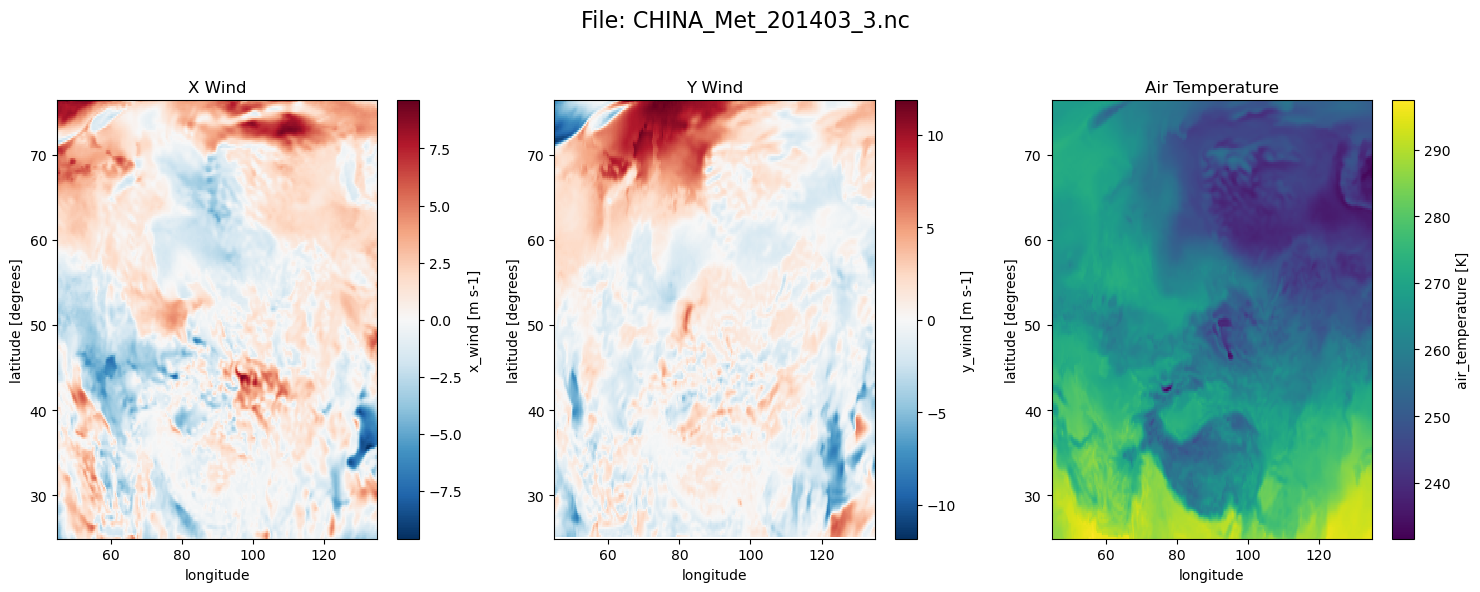

Longitude already in -180–180 format
Region 3 bounds: [24.984375, 80.015625, 44.929688, 135.07031]
  Dataset lat range: 25.003000259399414 to 76.24900018310547
  Dataset lon range: 45.01199658203125 to 134.77199865722656
Adjusted lon bounds: 45.012 to 134.772
Adjusted lat bounds: 25.003 to 76.249
x_wind NaNs before slicing: 0
*** Normal Slicing: not near 180 degree lat line ****
x_wind NaNs after slicing: 0
After slicing: (20, 221, 258, 2)
NaNs in slice: 0
['2014-03-01T00:00:00.000000000']
Dropping 2 duplicate values in 'longitude'
/work/scratch-nopw2/jeff/files/CHINA_Met_201403_4.nc
Plotting region 8 from file: /work/scratch-nopw2/jeff/files/CHINA_Met_201403_4.nc


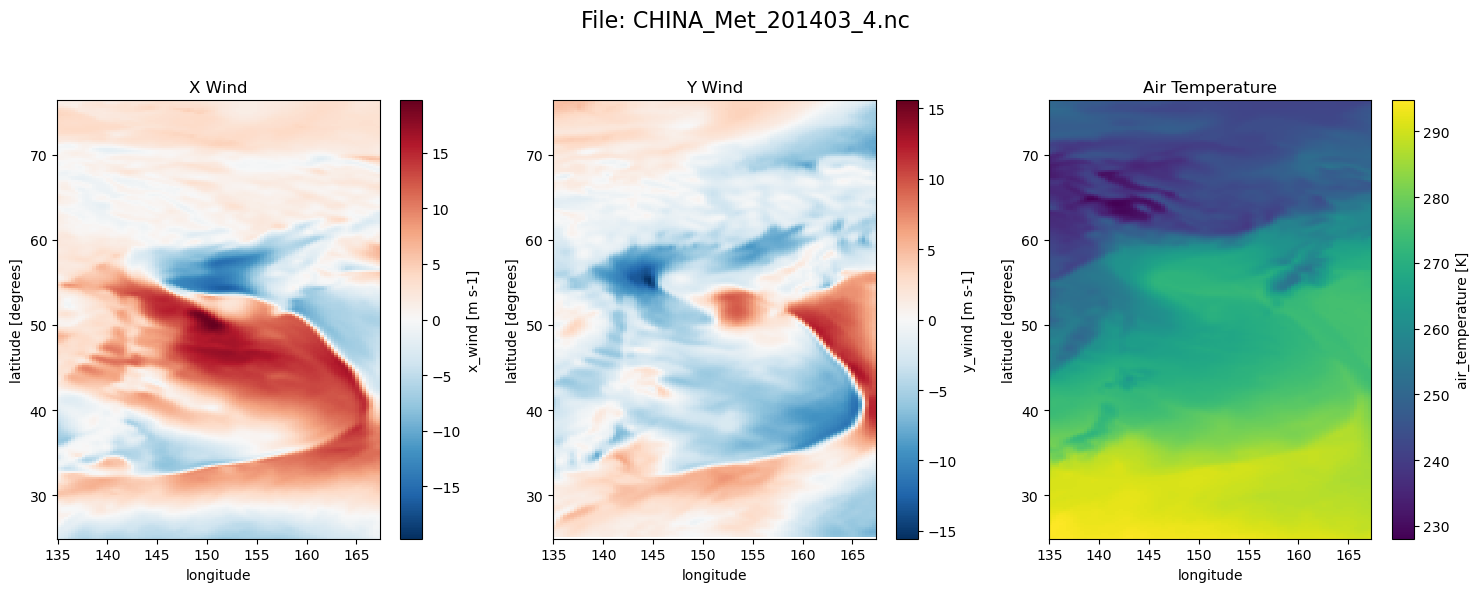

Longitude already in -180–180 format
Region 4 bounds: [24.984375, 80.015625, 134.92969, -134.92969]
  Dataset lat range: 25.003000259399414 to 76.24900018310547
  Dataset lon range: 135.1239986572266 to 167.15599865722658
Adjusted lon bounds: 135.124 to -134.92969
Adjusted lat bounds: 25.003 to 76.249
x_wind NaNs before slicing: 0
Using wraparound slicing for region 4
Skipping region 4: both wrap slices empty or all NaNs
loaded both datasets, merging [3, 4]
-------
Dataset 0 lat shape: (221,)
  min/max: 25.003 / 76.249
  sample: [25.003 25.237 25.471 25.705 25.939]
/work/scratch-nopw2/jeff/files/CHINA_Met_201403_7.nc
Plotting region 8 from file: /work/scratch-nopw2/jeff/files/CHINA_Met_201403_7.nc


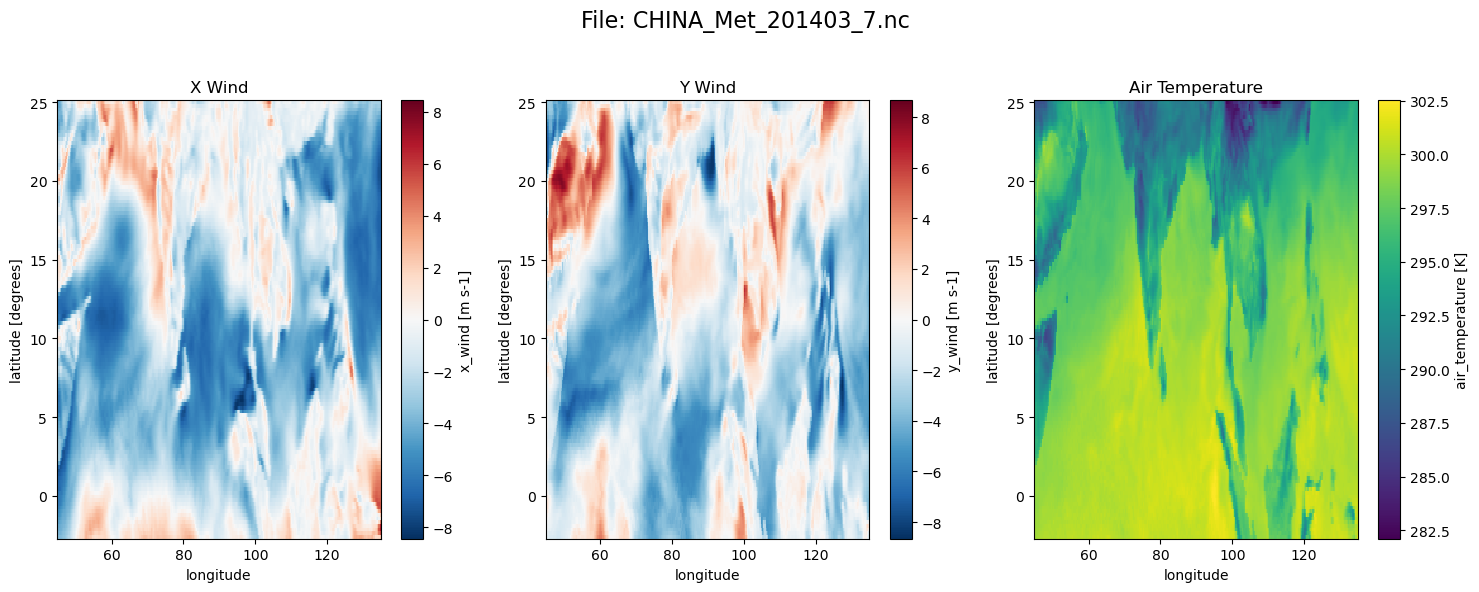

Longitude already in -180–180 format
Region 7 bounds: [-25.078125, 25.078125, 44.929688, 135.07031]
  Dataset lat range: -2.6090007934570316 to 25.003000259399414
  Dataset lon range: 45.01199658203126 to 134.77199865722656
Adjusted lon bounds: 45.012 to 134.772
Adjusted lat bounds: -2.609 to 25.003
x_wind NaNs before slicing: 0
*** Normal Slicing: not near 180 degree lat line ****
x_wind NaNs after slicing: 0
After slicing: (20, 120, 258, 2)
NaNs in slice: 0
['2014-03-01T00:00:00.000000000']
Dropping 2 duplicate values in 'longitude'
/work/scratch-nopw2/jeff/files/CHINA_Met_201403_8.nc
Plotting region 8 from file: /work/scratch-nopw2/jeff/files/CHINA_Met_201403_8.nc


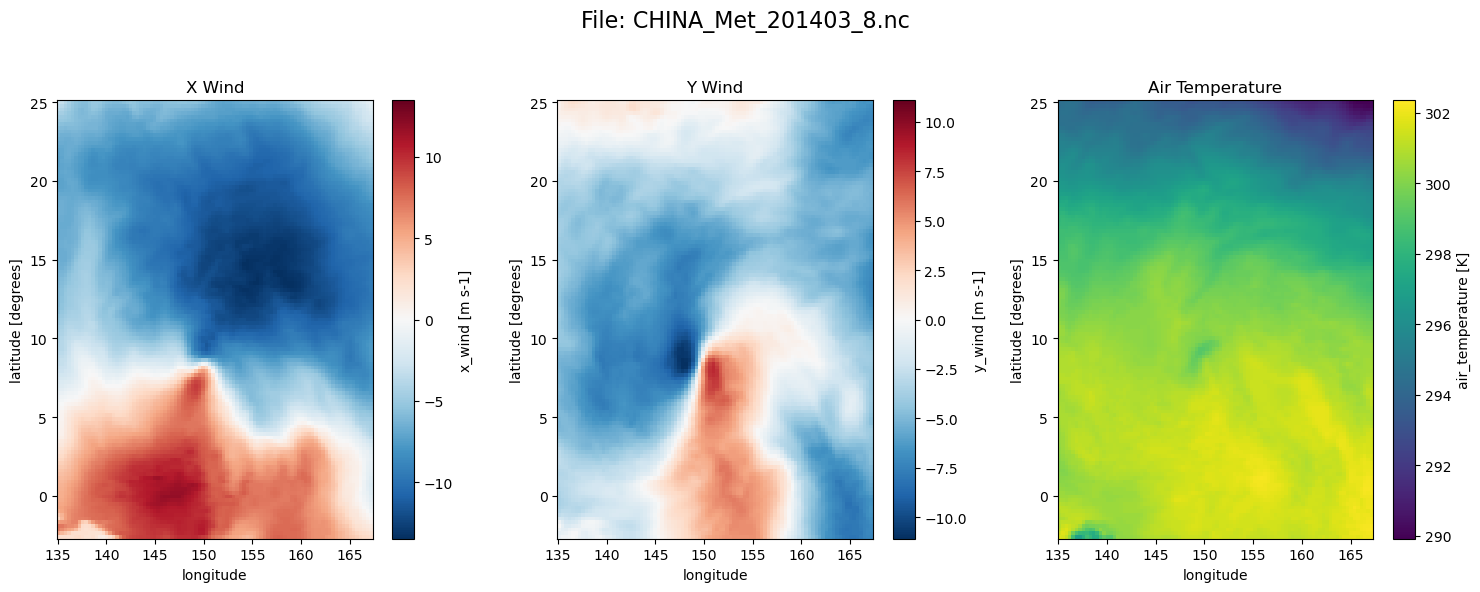

Longitude already in -180–180 format
Region 8 bounds: [-25.078125, 25.078125, 134.92969, -134.92969]
  Dataset lat range: -2.6090007934570316 to 25.003000259399414
  Dataset lon range: 135.1239986572266 to 167.15599865722658
Adjusted lon bounds: 135.124 to -134.92969
Adjusted lat bounds: -2.609 to 25.003
x_wind NaNs before slicing: 0
Using wraparound slicing for region 8
Skipping region 8: both wrap slices empty or all NaNs
loaded both datasets, merging [7, 8]
-------
Dataset 0 lat shape: (120,)
  min/max: -2.609 / 25.003
  sample: [-2.609 -2.375 -2.141 -1.907 -1.673]
fixing attrs
Included rows:
  Row 0: lat range 25.003 to 76.249
  Row 0: lon range 45.012 to 134.772
  Row 1: lat range -2.609 to 25.003
  Row 1: lon range 45.012 to 134.772
NaNs in first level/time: 30208
no attr units
no attr standard_name
no attr STASH
at the end <xarray.Dataset> Size: 71MB
Dimensions:                              (model_level_number: 20,
                                          latitude: 338, longitu

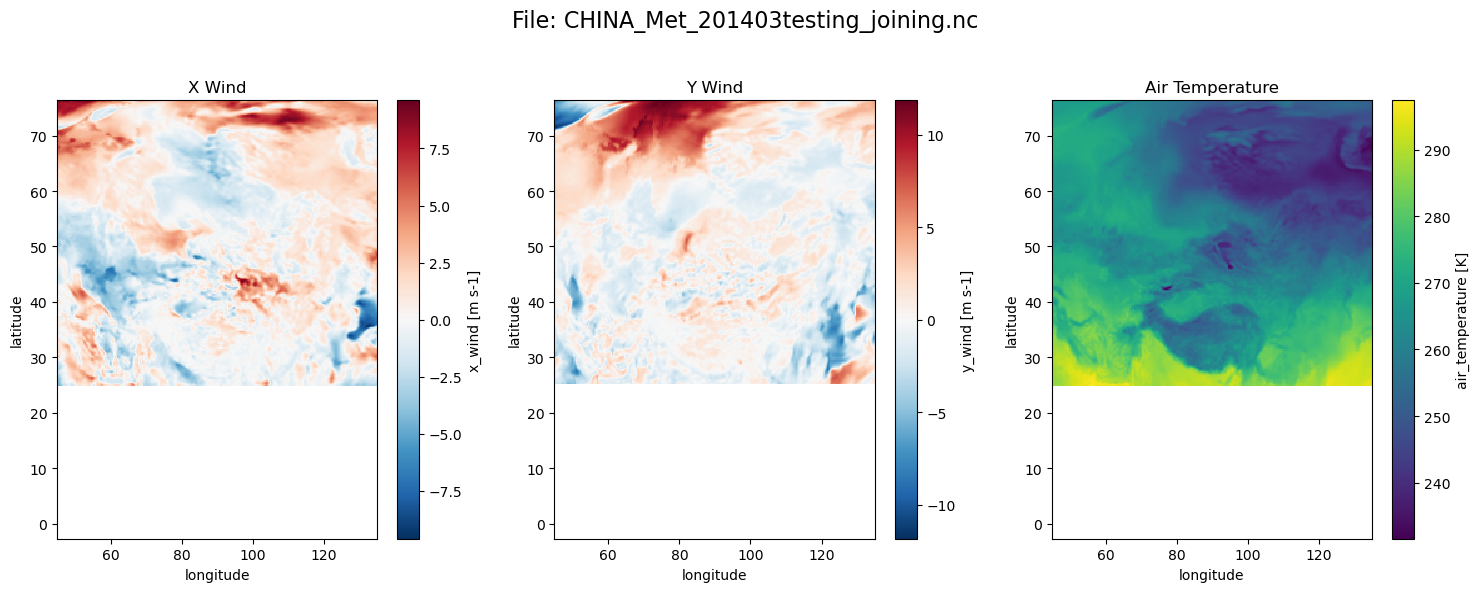

In [7]:
join_regions()

Trying agnostic met joining


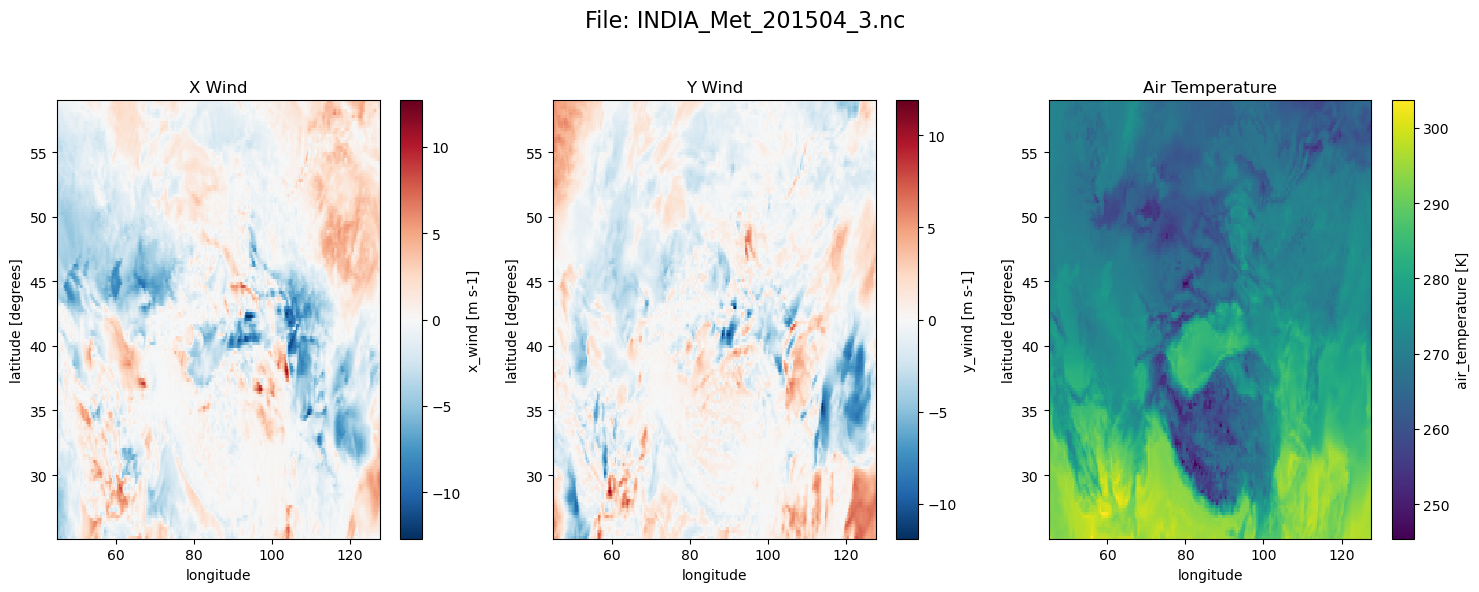


--- REGION 3 DEBUG ---
Raw bounds: [24.984375, 80.015625, 44.929688, 135.07031]

REGION 3 before slicing:
  Lon range in file: 45.144 to 127.512
  Lat range in file: 25.188 to 58.884
  Non-NaN x_wind points: 34602

REGION 3 after slicing:
  Longitude size: 237
  Latitude size: 146
  Non-NaN x_wind points: 34602
  Sliced lon range: 45.144 to 127.512
  Sliced lat range: 25.188 to 58.884
Converted bounds: lat 25.188 to 58.884, lon 45.144 to 127.512
Dataset longitude range: 45.144 to 127.512
Duplicate longitude values found in region 3: [68.376 92.664]
Dropping 2 duplicate values in 'longitude'
**** [124.344 124.696 125.048 125.4   125.752 126.104 126.456 126.808 127.16
 127.512]
**** [45.144 45.496 45.848 46.2   46.552 46.904 47.256 47.608 47.96  48.312]


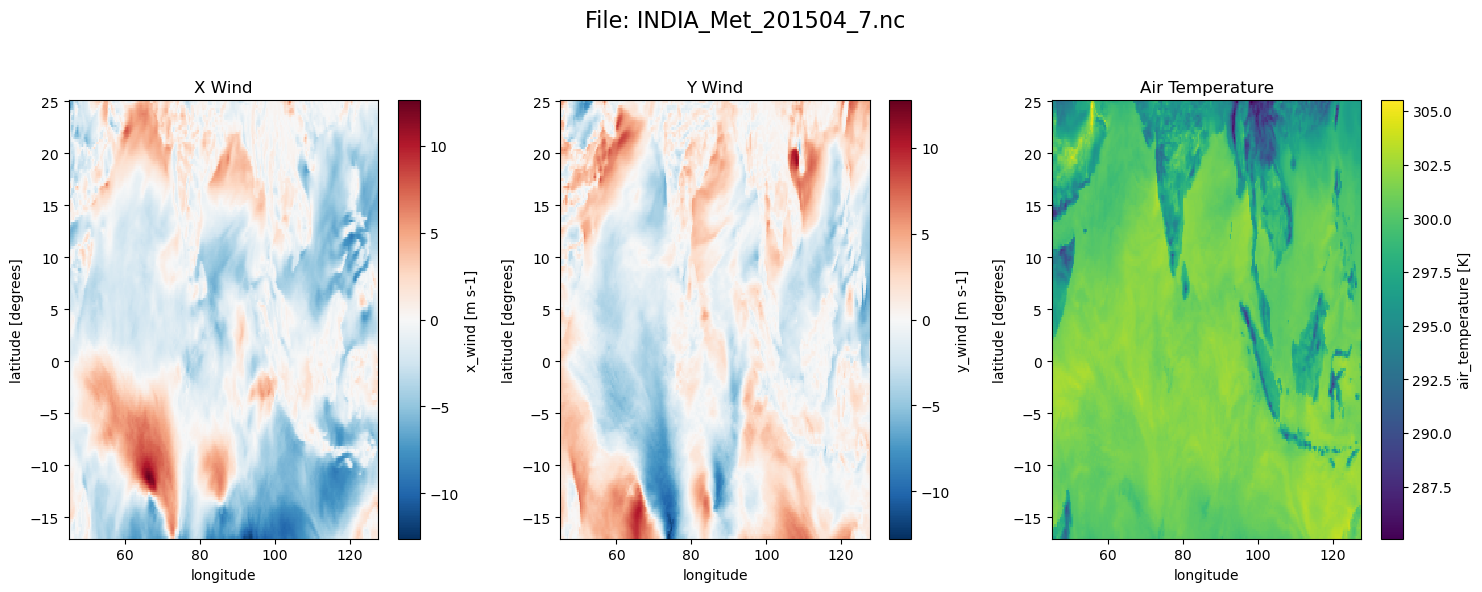


--- REGION 7 DEBUG ---
Raw bounds: [-25.078125, 25.078125, 44.929688, 135.07031]

REGION 7 before slicing:
  Lon range in file: 45.144 to 127.512
  Lat range in file: -16.932 to 24.954
  Non-NaN x_wind points: 42897

REGION 7 after slicing:
  Longitude size: 237
  Latitude size: 181
  Non-NaN x_wind points: 42897
  Sliced lon range: 45.144 to 127.512
  Sliced lat range: -16.932 to 24.954
Converted bounds: lat -16.932 to 24.954, lon 45.144 to 127.512
Dataset longitude range: 45.144 to 127.512
Duplicate longitude values found in region 7: [68.376 92.664]
Dropping 2 duplicate values in 'longitude'
**** [124.344 124.696 125.048 125.4   125.752 126.104 126.456 126.808 127.16
 127.512]
**** [45.144 45.496 45.848 46.2   46.552 46.904 47.256 47.608 47.96  48.312]
loaded both datasets, merging (3, 7)
fixing attrs
0
no attr units
no attr standard_name
no attr STASH
at the end <xarray.Dataset> Size: 126MB
Dimensions:                              (model_level_number: 20, time: 2,
                

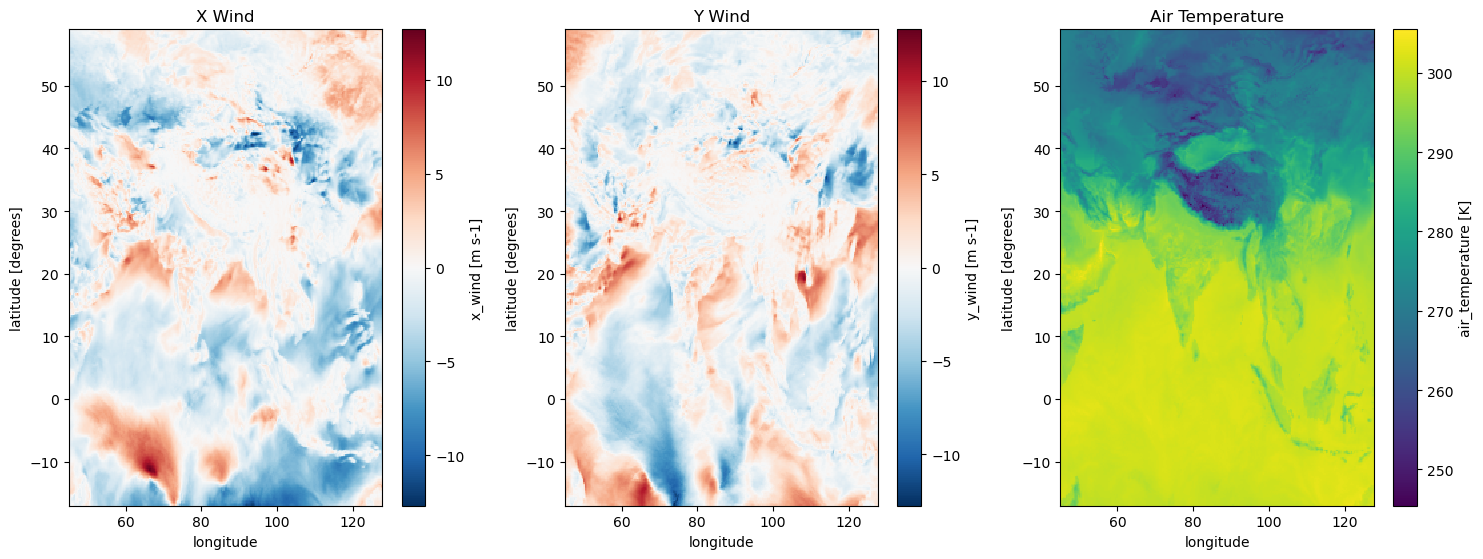

In [ ]:
# Round lat/lon coordinates BEFORE merging
def standardise_coords(ds, decimal_places=5):
    ds = ds.copy()
    ds['longitude'] = np.round(ds['longitude'], decimal_places)
    ds['latitude'] = np.round(ds['latitude'], decimal_places)
    return ds

    
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    print("Trying agnostic met joining")
    lat_arrays = []
    for column in zip(*region_grid): ###### Crucial change
        lat_datasets = []
        for region in column:
            file_path = f"{homefolder}{domain}_Met_{year_val}{month_str}_{region}.nc"

            #####ds = xr.open_dataset(file_path)
            ds = xr.open_dataset(file_path, chunks={"time": 10}) ####

            ds = ds.isel(time=slice(0, 2)) ###


            ### ----- New section start
            plot_met_file(file_path, time_index=0, level_index=0)

            # ----- Check with Elena this rounding is okay - don't want to cause alignment issues with fps or static variables
            ds = ds.assign_coords(
                longitude=np.round(ds.longitude, 4),
                latitude=np.round(ds.latitude, 4)
            )
            print(f"\n--- REGION {region} DEBUG ---")
            print(f"Raw bounds: {region_bounds[region]}")
            bounds = region_bounds[region]

            print(f"\nREGION {region} before slicing:")
            print(f"  Lon range in file: {ds.longitude.min().values} to {ds.longitude.max().values}")
            print(f"  Lat range in file: {ds.latitude.min().values} to {ds.latitude.max().values}")
            print(f"  Non-NaN x_wind points: {ds['x_wind'].isel(model_level_number=0, time=0).notnull().sum().values}")

            
            # Extract and convert
            # Ensure ds.longitude is in -180 to 180 format before this
            lon_data_min = float(ds.longitude.min())
            lon_data_max = float(ds.longitude.max())
            
            # Clip bounds to the available data range
            lon_min = max(region_bounds[region][2], lon_data_min)
            lon_max = min(region_bounds[region][3], lon_data_max)

            # Handle wraparound cases, where it crosses the 180 degree lon line ####
            if lon_min > lon_max:
                print(f"Wraparound slice for region {region}")
            
                # Part 1: lon_min to 180 (but clipped)
                part1_min = max(lon_min, lon_data_min)
                part1_max = min(180, lon_data_max)
                ds1 = ds.sel(longitude=slice(part1_min, part1_max))
            
                # Part 2: -180 to lon_max (but clipped)
                part2_min = max(-180, lon_data_min)
                part2_max = min(lon_max, lon_data_max)
                ds2 = ds.sel(longitude=slice(part2_min, part2_max))
            
                # Only concat non-empty slices
                valid_parts = [part for part in [ds1, ds2] if part.longitude.size > 0]
                if not valid_parts:
                    print(f"Skipping region {region}: no valid data after wraparound slicing")
                    continue
                ds = xr.concat(valid_parts, dim="longitude")
            
            else:
                # Standard case, just clip to valid data range
                lon_min = max(lon_min, lon_data_min)
                lon_max = min(lon_max, lon_data_max)
                ds = ds.sel(longitude=slice(lon_min, lon_max))
            ds = standardise_coords(ds) ####
            
            
            print(f"\nREGION {region} after slicing:")
            print(f"  Longitude size: {ds.longitude.size}")
            print(f"  Latitude size: {ds.latitude.size}")
            print(f"  Non-NaN x_wind points: {ds['x_wind'].isel(model_level_number=0, time=0).notnull().sum().values}")
            print(f"  Sliced lon range: {ds.longitude.min().values} to {ds.longitude.max().values}")
            print(f"  Sliced lat range: {ds.latitude.min().values} to {ds.latitude.max().values}")



            lat_min = max(region_bounds[region][0], float(ds.latitude.min()))
            lat_max = min(region_bounds[region][1], float(ds.latitude.max()))
            ds = ds.sel(latitude=slice(lat_min, lat_max))
            # Print after transformation
            print(f"Converted bounds: lat {lat_min} to {lat_max}, lon {lon_min} to {lon_max}")
            print(f"Dataset longitude range: {ds.longitude.min().values} to {ds.longitude.max().values}")

            
            ### New section end


            ''' ###
            bounds = region_bounds[region]
            ds = ds.sel(latitude=slice(bounds[0], bounds[1]),
                        longitude=slice(bounds[2], bounds[3]))
            '''
            # Drop duplicate longitudes and sort
            ds = ds.sortby("longitude")

            # Get longitude values
            longitudes = ds["longitude"].values

            # Count occurrences
            unique, counts = np.unique(longitudes, return_counts=True)

            # Find duplicates
            duplicates = unique[counts > 1]
            
            if duplicates.size > 0:
                print(f"Duplicate longitude values found in region {region}: {duplicates}")
                if DEBUG_DUPLICATES:
                    for dup in duplicates:
                        idxs = np.where(longitudes == dup)[0]
                        print(f"  Value {dup} appears at indices {idxs}")
            else:
                print(f"No duplicate longitudes in region {region}")

            ds = drop_duplicate_coords(ds, "longitude")
            
            lat_datasets.append(ds)
            print("****", ds.longitude.values[-10:])  # for both Region 7 and Region 8 ####

            print("****", ds.longitude.values[:10])  # for both Region 7 and Region 8 ####

        print(f"loaded both datasets, merging {column}")
        # Merge regions in the same lon row along latitude
        merged_row = xr.concat(lat_datasets, dim="latitude")
        merged_copy = merged_row.copy()
        merged_row = merged_row.sortby("latitude").drop_duplicates(dim="latitude")
        ####merged_row = merged_row.sortby("longitude").drop_duplicates(dim="longitude")
        merged_row = merged_row.sortby(["latitude", "longitude"]) #####

        
        lat_arrays.append(merged_row)

    print("fixing attrs")
    
    met = xr.concat(lat_arrays, dim="longitude")  


    #####met = met.drop_duplicates(dim="longitude")
    met = met.sortby(["latitude", "longitude", "time"])
    met = met.transpose("model_level_number", "latitude", "longitude", "time")
    met = met.chunk(dict(latitude=-1)).interpolate_na(dim = 'latitude', #max_gap = 3
                            )
    print(np.sum(np.isnan(met.y_wind[0,:,:,0].values)))
    for attr in ["units", "standard_name", "STASH"]:
      try:
        met.attrs.pop(attr)
      except:
        print(f"no attr {attr}")
        continue
    met.attrs["author"] = config.get("met_extract_author", "")
    met.attrs["created"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    met.attrs["transformations"] = "interpolated linearly in space to NAME resolution"#, interpolated linearly in time from 3-hourly to hourly"
    print("at the end", met)
    
    filename = config.get("met_save_directory", "")+domain+"_Met_"+str(year_val)+month_str+"joiny.nc"

    ###met.load().to_netcdf(filename) 


            
    variables = ['x_wind', 'y_wind', 'air_temperature']
    

    ds = met
    level_index = 0
    time_index=0
    
    # Create subplots
    fig, axes = plt.subplots(1, len(variables), figsize=(5 * len(variables), 6))
    if len(variables) == 1:
        axes = [axes]  # Ensure it's iterable
    
    for i, var in enumerate(variables):
        if var in ds:
            try:
                data = ds[var]
                # Handle 4D vs 3D gracefully
                if 'model_level_number' in data.dims and 'time' in data.dims:
                    data = data.isel(model_level_number=level_index, time=time_index)
                elif 'time' in data.dims:
                    data = data.isel(time=time_index)
                elif 'model_level_number' in data.dims:
                    data = data.isel(model_level_number=level_index)
                
                data.plot(ax=axes[i])
                axes[i].set_title(var.replace('_', ' ').title())
            except Exception as plot_err:
                print(f"Could not plot {var}: {plot_err}")
                axes[i].set_visible(False)
        else:
            print(f"Variable '{var}' not found in {file_name}")
            axes[i].set_visible(False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    #ds.close()


    

if delete_files:
    os.system(f'rm -r {homefolder}{domain}_Met_{year_val}{month_str}_*')

In [49]:
np.sum(np.isnan(met.y_wind.values[0,:,:,0]))

348

In [53]:
metsmall = met.isel(time=slice(0,2))

In [60]:
np.sum(np.isnan(metsmall.chunk(dict(longitude=-1)).y_wind.values))

13920

In [67]:
interped = metsmall.chunk(dict(latitude=-1)).interpolate_na(dim="latitude")

In [66]:
np.sum(np.isnan(metsmall.chunk(dict(latitude=-1)).interpolate_na(dim="latitude").y_wind.values))

0

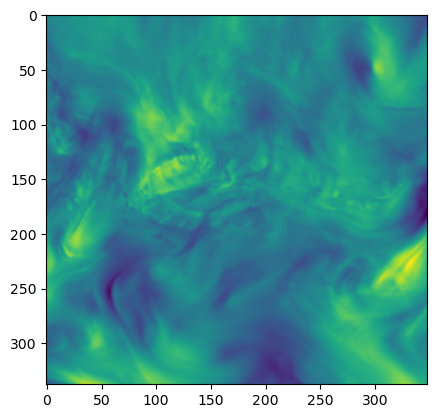

In [68]:
plt.imshow(interped.y_wind[8,:,:,1])

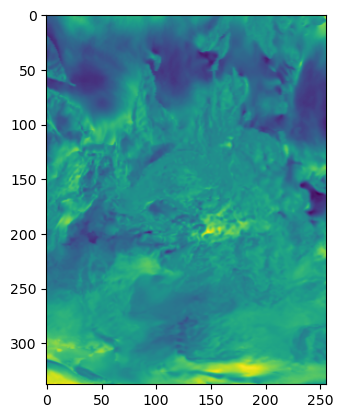

In [38]:
plt.imshow(merged_row.x_wind[0,:,:,0])

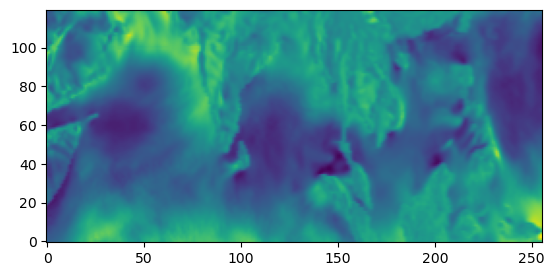

In [30]:
plt.imshow(merged_copy.x_wind[0,:,:,0], origin="lower")

In [34]:
lat_datasets[0]

<xarray.Dataset> Size: 51MB
Dimensions:                              (model_level_number: 20, time: 2,
                                          latitude: 120, longitude: 256)
Coordinates:
  * model_level_number                   (model_level_number) int32 80B 1 ... 57
  * time                                 (time) datetime64[ns] 16B 2014-03-01...
    level_height                         (model_level_number) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    sigma                                (model_level_number) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
  * longitude                            (longitude) float64 2kB 45.01 ... 134.8
  * latitude                             (latitude) float64 960B -2.609 ... 25.0
Data variables:
    air_pressure                         (model_level_number, latitude, longitude, time) float64 10MB dask.array<chunksize=(20, 120, 256, 2), meta=np.ndarray>
    air_pressure_at_sea_level            (latitude, longitude, time) float64 492kB dask.array<chunksize=(120, 256, 2), meta=np.ndarray>
    air_temperature                      (model_level_number, latitude, longitude, time) float64 10MB dask.array<chunksize=(20, 120, 256, 2), meta=np.ndarray>
    atmosphere_boundary_layer_thickness  (latitude, longitude, time) float64 492kB dask.array<chunksize=(120, 256, 2), meta=np.ndarray>
    surface_air_pressure                 (latitude, longitude, time) float64 492kB dask.array<chunksize=(120, 256, 2), meta=np.ndarray>
    upward_air_velocity                  (model_level_number, latitude, longitude, time) float64 10MB dask.array<chunksize=(20, 120, 256, 2), meta=np.ndarray>
    x_wind                               (model_level_number, latitude, longitude, time) float64 10MB dask.array<chunksize=(20, 120, 256, 2), meta=np.ndarray>
    y_wind                               (model_level_number, latitude, longitude, time) float64 10MB dask.array<chunksize=(20, 120, 256, 2), meta=np.ndarray>

In [17]:
met

<xarray.Dataset> Size: 388MB
Dimensions:                              (model_level_number: 20,
                                          latitude: 338, longitude: 696, time: 2)
Coordinates:
  * model_level_number                   (model_level_number) int32 80B 1 ... 57
  * time                                 (time) datetime64[ns] 16B 2014-03-01...
  * latitude                             (latitude) float64 3kB -2.609 ... 76.25
  * longitude                            (longitude) float64 6kB 45.01 ... 167.2
    level_height                         (model_level_number) float32 80B 20....
    sigma                                (model_level_number) float32 80B 0.9...
Data variables:
    air_pressure                         (model_level_number, latitude, longitude, time) float64 75MB dask.array<chunksize=(20, 84, 69, 2), meta=np.ndarray>
    air_pressure_at_sea_level            (latitude, longitude, time) float64 4MB dask.array<chunksize=(84, 69, 2), meta=np.ndarray>
    air_temperature                      (model_level_number, latitude, longitude, time) float64 75MB dask.array<chunksize=(20, 84, 69, 2), meta=np.ndarray>
    atmosphere_boundary_layer_thickness  (latitude, longitude, time) float64 4MB dask.array<chunksize=(84, 69, 2), meta=np.ndarray>
    surface_air_pressure                 (latitude, longitude, time) float64 4MB dask.array<chunksize=(84, 69, 2), meta=np.ndarray>
    upward_air_velocity                  (model_level_number, latitude, longitude, time) float64 75MB dask.array<chunksize=(20, 84, 69, 2), meta=np.ndarray>
    x_wind                               (model_level_number, latitude, longitude, time) float64 75MB dask.array<chunksize=(20, 84, 69, 2), meta=np.ndarray>
    y_wind                               (model_level_number, latitude, longitude, time) float64 75MB dask.array<chunksize=(20, 84, 69, 2), meta=np.ndarray>
Attributes:
    author:           Jeff Clark (kr21883)
    created:          2025-07-04 14:16
    transformations:  interpolated linearly in space to NAME resolution